In [ ]:
# Ellen Davenport April 2025
# This script takes profiles from the MITgcm that contain both EquatorMix and TPOSE data.
# It includes the estimation of density and buoyancy frequency for both data sets and creates figures to compare between the datasets

In [1]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
from fastjmd95 import rho
import sys
import cmocean.cm as cmo
warnings.filterwarnings("ignore")

filename = 'fastCTD_prof_model.nc'
ds_model = xr.open_dataset(filename)

/data/SO3/edavenport/TPOSE6_EqMixProf/fastCTD_prof_model.nc


In [2]:
# get rid of bad data
ds_model.prof_T[9500:10500] = np.nan
ds_model.prof_Testim[9500:10500] = np.nan
ds_model.prof_S[9500:10500] = np.nan
ds_model.prof_Sestim[9500:10500] = np.nan

# set meaningful depth values
ds_model['iDEPTH'] = ds_model.prof_depth

In [3]:
sigma_0 = (rho(ds_model.prof_Sestim, ds_model.prof_Testim, 0))
sigma_dz = (sigma_0[:,1:].values - sigma_0[:,:-1].values)/(ds_model.prof_depth[1:].values[np.newaxis,:]-ds_model.prof_depth[:-1].values[np.newaxis,:])

tmp = ds_model.prof_Testim.copy(deep=True)
tmp.values[:,:-1] = sigma_dz
tmp.name = 'drho_dz'
sigma_dz = tmp 
N2 = sigma_dz * (9.8/1035) # 1035 is reference density TPOSE6
N = (np.sqrt(N2) * 3600)/(2*np.pi) # convert  to cph


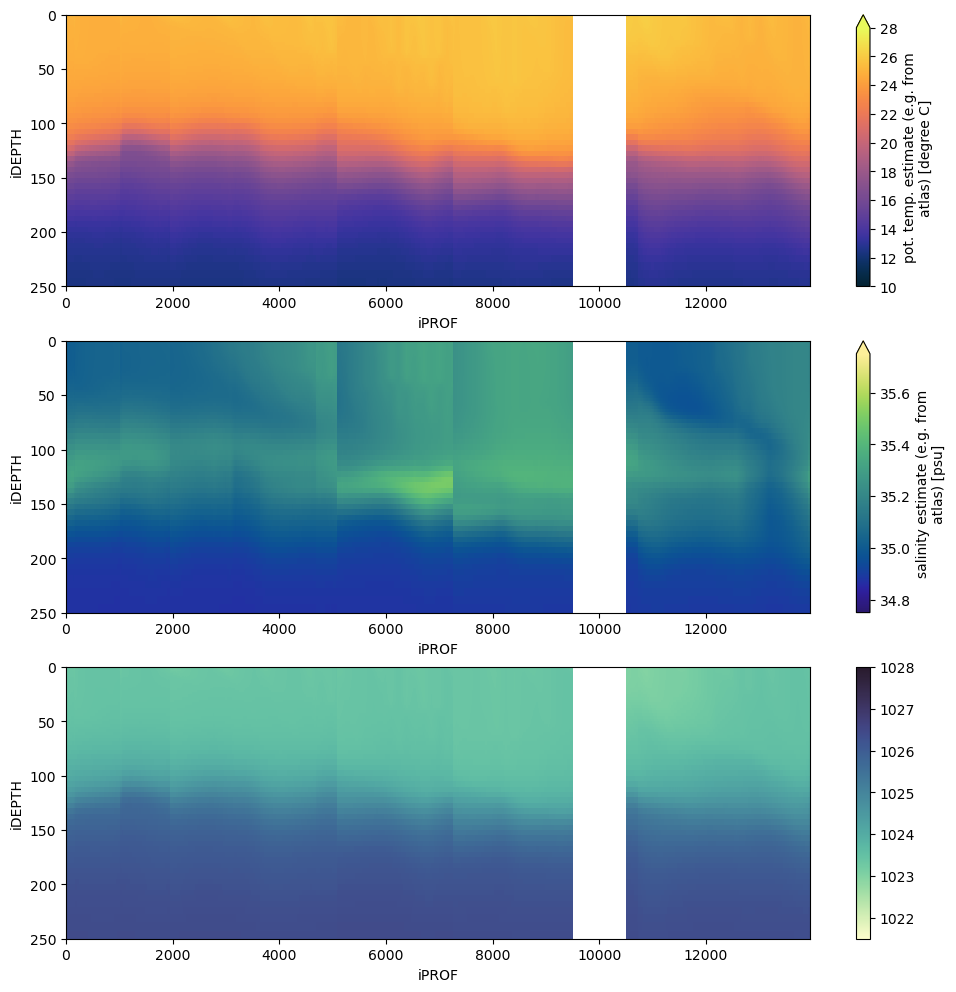

In [61]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3)
ds_model.prof_Testim.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[0],cmap=cmo.thermal, vmin=10, vmax=28)
ax[0].invert_yaxis()
ds_model.prof_Sestim.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[1],cmap=cmo.haline, vmin=34.75, vmax=35.75)
ax[1].invert_yaxis()
sigma_0.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[2],cmap=cmo.deep,vmin=1021.5,vmax=1028)
ax[2].invert_yaxis()

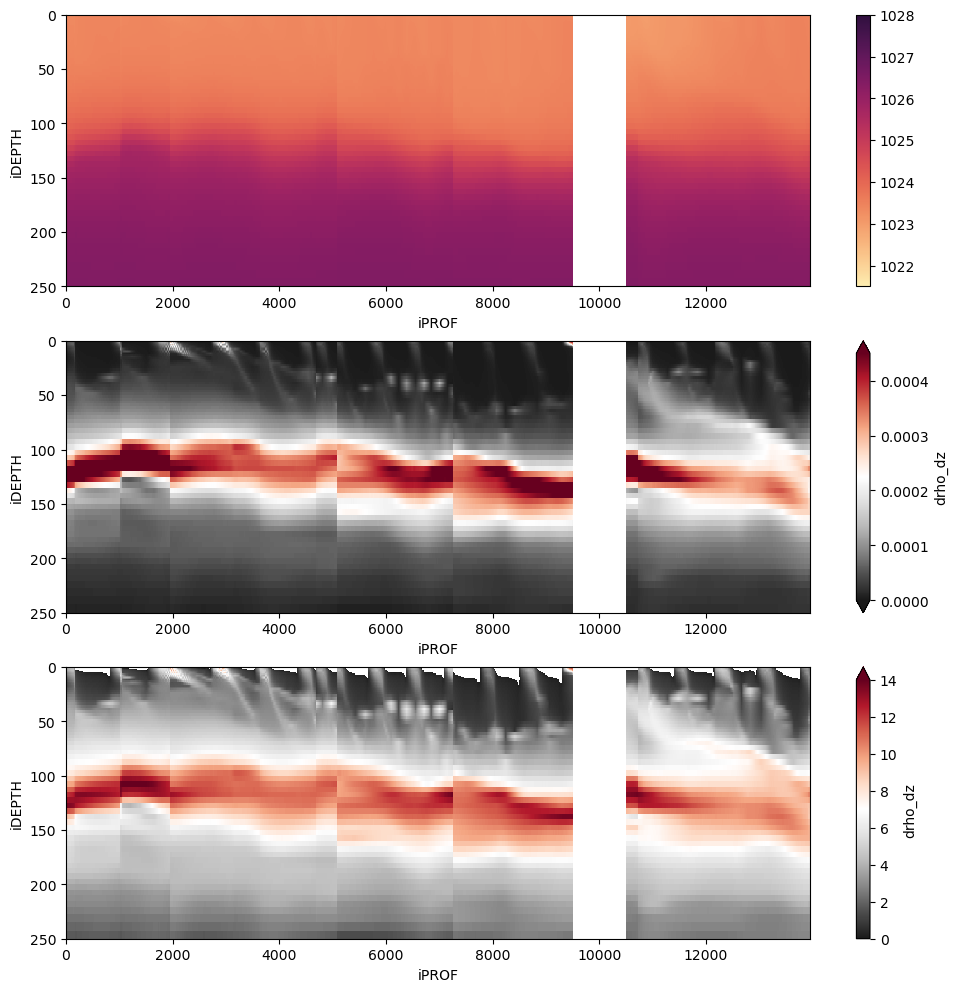

In [48]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3)
sigma_0.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[0],cmap=cmo.matter, vmin=1021.5,vmax=1028)
ax[0].invert_yaxis()
N2.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[1],cmap='RdGy_r',vmin=0.0,vmax=4.5e-4)
ax[1].invert_yaxis()
N.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[2],cmap='RdGy_r',vmin=0.0,vmax=14.0)
ax[2].invert_yaxis()

In [4]:
# estimate N2 and N from the EquatorMix data
sigma_0_eq = (rho(ds_model.prof_S, ds_model.prof_T, 0))
sigma_dz_eq = (sigma_0_eq[:,1:].values - sigma_0_eq[:,:-1].values)/(ds_model.prof_depth[1:].values[np.newaxis,:]-ds_model.prof_depth[:-1].values[np.newaxis,:])

tmp = ds_model.prof_T.copy(deep=True)
tmp.values[:,:-1] = sigma_dz_eq
tmp.name = 'drho_dz'
sigma_dz_eq = tmp 

N2_eq = sigma_dz_eq * (9.8/1035)
N_eq = (np.sqrt(N2_eq) * 3600)/(2*np.pi)

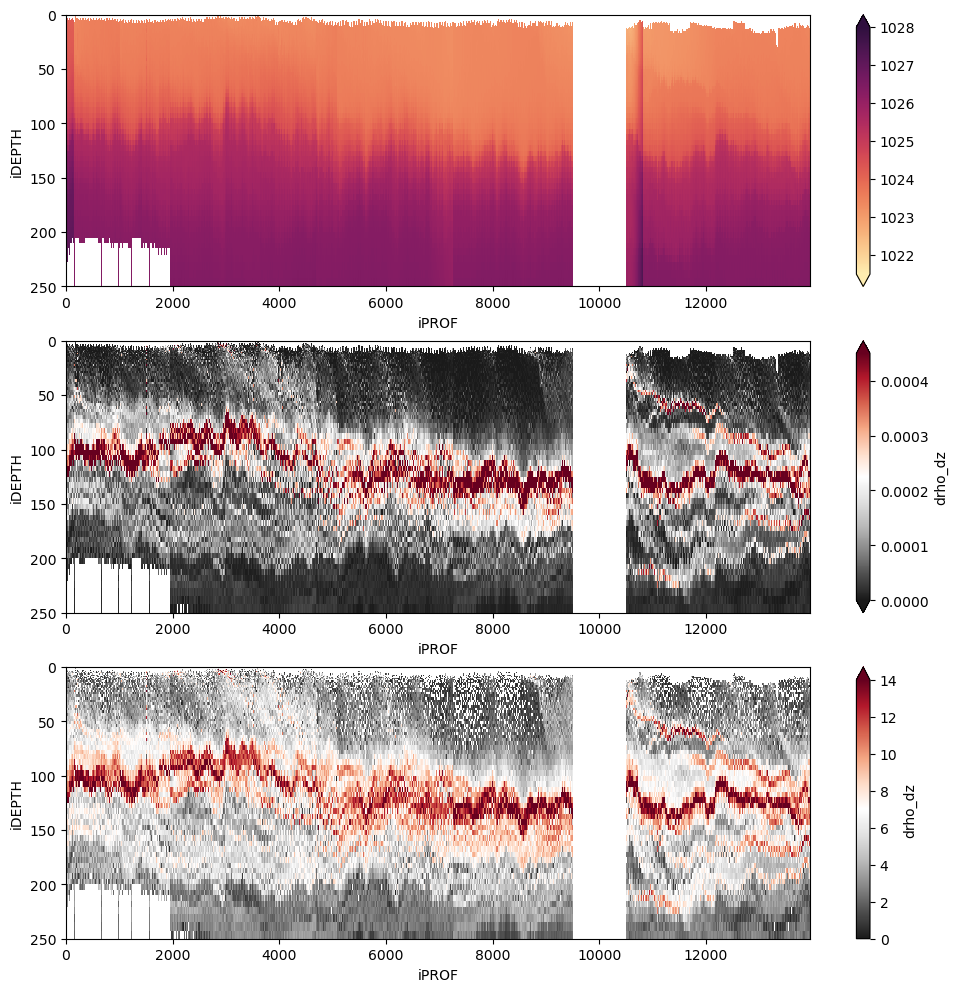

In [63]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3)
sigma_0_eq.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[0],cmap=cmo.matter, vmin=1021.5,vmax=1028)
ax[0].invert_yaxis()
N2_eq.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[1],cmap='RdGy_r',vmin=0,vmax=4.5e-4)
ax[1].invert_yaxis()
N_eq.sel(iDEPTH=slice(0,250)).T.plot(ax=ax[2],cmap='RdGy_r',vmin=0,vmax=14)
ax[2].invert_yaxis()

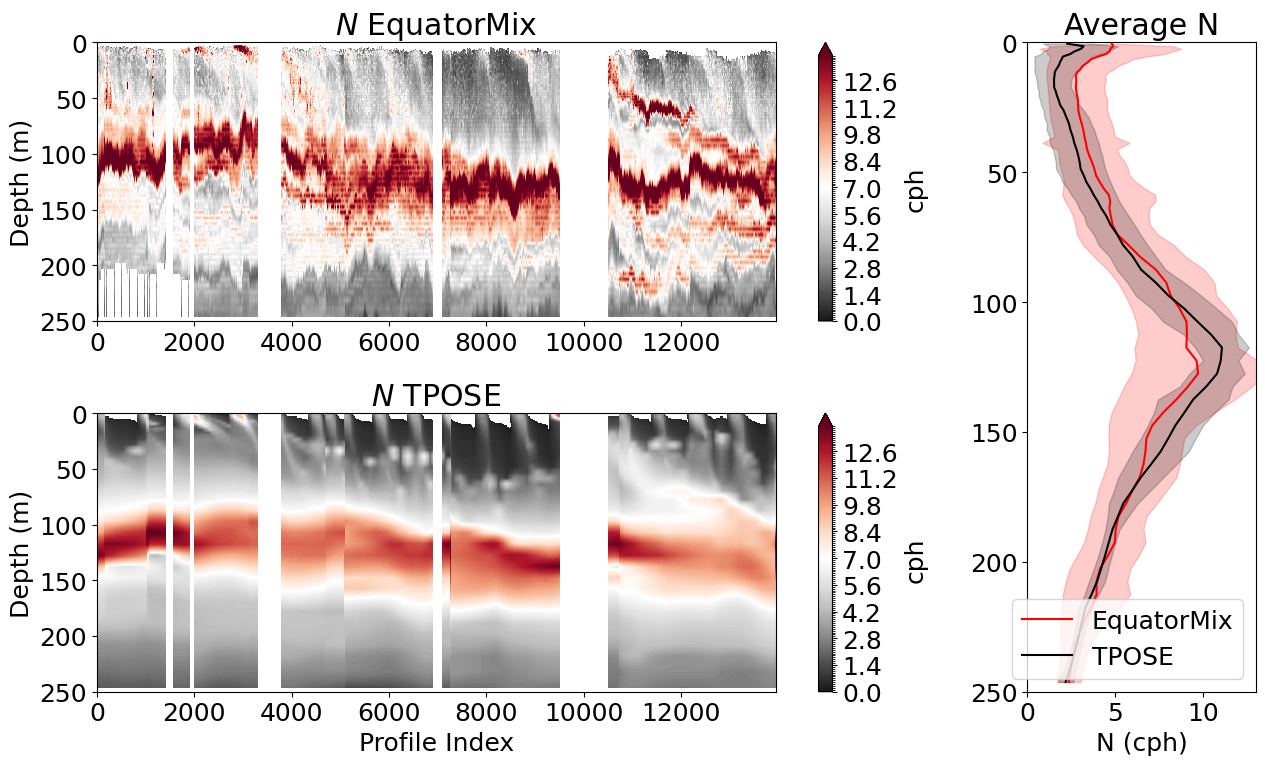

In [7]:
import matplotlib.gridspec as gs
plt.rcParams['font.size'] = 18

# get rid of additional bad data before taking the mean and std deviation (identified as profiles with anomalously large stratification at all depths)
N_eq_clean = N_eq.copy(deep=True)
N_eq_clean[1400:1575,:] = np.nan
N_eq_clean[1900:2000,:] = np.nan
N_eq_clean[3300:3800,:] = np.nan
N_eq_clean[6900:7100,:] = np.nan

N_clean = N.copy(deep=True)
N_clean[1400:1575,:] = np.nan
N_clean[1900:2000,:] = np.nan
N_clean[3300:3800,:] = np.nan
N_clean[6900:7100,:] = np.nan
levels = np.arange(0,14.0,0.1)

# take mean and std deviation of N in both model and data
N_eq_clean_mean = N_eq_clean.mean(dim='iPROF')
N_eq_clean_std = N_eq_clean.std(dim='iPROF')
N_clean_mean = N_clean.mean(dim='iPROF')
N_clean_std = N_clean.std(dim='iPROF')

# ----------------------------------------------------------------------------PLOTTING ----------------------------------------------------------------------#
fig = plt.figure(figsize=(13,8))
grid = gs.GridSpec(6, 12)

ax0 = plt.subplot(grid[0:3,0:9])
ax1 = plt.subplot(grid[3:,0:9])
ax2 = plt.subplot(grid[:,9:])

N_eq_clean.sel(iDEPTH=slice(0,250)).T.plot.contourf(ax=ax0,cmap='RdGy_r',levels=levels,cbar_kwargs={'label':'cph'})
ax0.invert_yaxis()
ax0.set_ylim(250,0)
ax0.set_title('$N$ EquatorMix')
ax0.set_xlabel('')
ax0.set_ylabel('Depth (m)')
N_clean.sel(iDEPTH=slice(0,250)).T.plot.contourf(ax=ax1,cmap='RdGy_r',levels=levels,cbar_kwargs={'label':'cph'})
ax1.invert_yaxis()
ax1.set_ylim(250,0)
ax1.set_title('$N$ TPOSE')
ax1.set_xlabel('Profile Index')
ax1.set_ylabel('Depth (m)')

ax2.plot(N_eq_clean_mean.sel(iDEPTH=slice(0,250)),ds_model.prof_depth.sel(iDEPTH=slice(0,250)),color='r',label='EquatorMix')
ax2.fill_betweenx(ds_model.prof_depth.sel(iDEPTH=slice(0,250)),(N_eq_clean_mean-N_eq_clean_std).sel(iDEPTH=slice(0,250)),(N_eq_clean_mean+N_eq_clean_std).sel(iDEPTH=slice(0,250)),color='r',alpha=0.2)
ax2.plot(N_clean_mean.sel(iDEPTH=slice(0,250)),ds_model.prof_depth.sel(iDEPTH=slice(0,250)),color='k',label='TPOSE')
ax2.fill_betweenx(ds_model.prof_depth.sel(iDEPTH=slice(0,250)),(N_clean_mean-N_clean_std).sel(iDEPTH=slice(0,250)),(N_clean_mean+N_clean_std).sel(iDEPTH=slice(0,250)),color='k',alpha=0.2)
ax2.set_xlabel('N (cph)')
ax2.invert_yaxis()
ax2.set_ylabel('')
ax2.set_ylim(250,0)
ax2.legend(loc='lower right')
ax2.set_xlim(0.0,13.0)
ax2.set_title('Average N')

plt.tight_layout()